Nâng độ chính xác cho bộ dữ liệu mỉa mai 

[Paper Bert](https://arxiv.org/pdf/1810.04805.pdf): BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding

## 1. Load dữ liệu

In [ ]:

!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json -O /tmp/sarcasm.json
  
import json

with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

--2021-08-04 08:43:44--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2021-08-04 08:43:44 (176 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [ ]:
datastore[0]

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
 'is_sarcastic': 0}

## 2. Tokenizer

In [ ]:
dataset = []
label_dataset = []

for item in datastore:
    dataset.append(item["headline"])
    label_dataset.append(item["is_sarcastic"])

In [ ]:
dataset[:10], label_dataset[:10]

(["former versace store clerk sues over secret 'black code' for minority shoppers",
  "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  "mom starting to fear son's web series closest thing she will have to grandchild",
  'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'j.k. rowling wishes snape happy birthday in the most magical way',
  "advancing the world's women",
  'the fascinating case for eating lab-grown meat',
  'this ceo will send your kids to school, if you work for his company',
  'top snake handler leaves sinking huckabee campaign',
  "friday's morning email: inside trump's presser for the ages"],
 [0, 0, 1, 1, 0, 0, 0, 0, 1, 0])

In [ ]:
import numpy as np

dataset = np.array(dataset)
label_dataset = np.array(label_dataset)

In [ ]:
train_size = 0.8
size = int(len(dataset) * train_size)

train_sentence = dataset[:size]
test_sentence = dataset[size:]

train_label = label_dataset[:size]
test_label = label_dataset[size:]

In [ ]:
len(train_sentence), len(test_sentence)

(21367, 5342)

## 2. Load thư viện sử dụng BERT

In [ ]:
pip install -q tf-models-official==2.4.0


In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

## 3. Tải pre-trained model

In [ ]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

In [ ]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

In [ ]:
tokens = tokenizer.tokenize(dataset[2])
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['mom', 'starting', 'to', 'fear', 'son', "'", 's', 'web', 'series', 'closest', 'thing', 'she', 'will', 'have', 'to', 'grand', '##child']
[3566, 3225, 2000, 3571, 2365, 1005, 1055, 4773, 2186, 7541, 2518, 2016, 2097, 2031, 2000, 2882, 19339]


In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])


[101, 102]

In [ ]:
train_size = 0.8
size = int(len(dataset) * train_size)

train_sentence = dataset[:size]
test_sentence = dataset[size:]

train_label = label_dataset[:size]
test_label = label_dataset[size:]

## 4. Chuẩn vị đầu vào cho Bert

Hàm encode_sentence có nhiệm vụ tokenize một câu và chuyển thành ids tương tự giống các tokenizer thông thường

In [ ]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)


In [ ]:
def bert_encode(sentences, tokenizer):
  tokenized_sentences = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in sentences])

  # CLS TOken đứng đầu câu
  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tokenized_sentences.shape[0]
  
  input_word_ids = tf.concat([cls, tokenized_sentences], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  
  type_s1 = tf.zeros_like(tokenized_sentences)
  
  input_type_ids = tf.concat(
      [type_cls, type_s1], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

Tokenize features tập train

In [ ]:
train_inputs = bert_encode(train_sentence, tokenizer)
train_label_tensors = tf.constant(train_label)

Tokenize features tập test

In [ ]:
test_inputs = bert_encode(test_sentence, tokenizer)
test_label_tensors = tf.constant(test_label)

## 5. Khởi động Bert

Tải cấu trúc của Bert.

Mô hình cơ bản Bert Base bao gồm 12 lớp Transformer Encoder

In [ ]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

Khởi tạo Bert

In [ ]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

Hiển thị mô hình

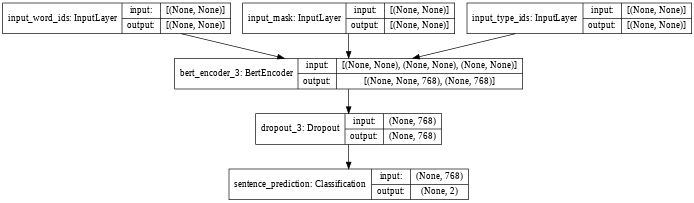

In [ ]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

Feedforward thử dữ liệu

In [ ]:
test_batch = {key: val[:10] for key, val in train_inputs.items()}

In [ ]:
bert_classifier(
    test_batch, training=True
).numpy()

array([[ 0.37821484, -0.09909362],
       [ 0.3555146 , -0.5968945 ],
       [ 0.15664597, -0.16548182],
       [ 0.16028711, -0.1708988 ],
       [ 0.1566822 , -0.19155689],
       [ 0.19265974, -0.01749988],
       [ 0.28543812, -0.16573502],
       [-0.00624533, -0.10158376],
       [ 0.14110593, -0.25614244],
       [ 0.2097215 , -0.21427381]], dtype=float32)

Khởi tạo checkpoint

In [ ]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

## 6. Tiến hành training

In [ ]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(train_label)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      train_inputs, train_label_tensors,
      batch_size=32,
      validation_data=(test_inputs, test_label_tensors),
      epochs=epochs)

Epoch 1/3
668/668 [==============================] - 189s 265ms/step - loss: 0.3348 - accuracy: 0.8428 - val_loss: 0.2094 - val_accuracy: 0.9115
Epoch 2/3
668/668 [==============================] - 176s 263ms/step - loss: 0.1371 - accuracy: 0.9497 - val_loss: 0.2086 - val_accuracy: 0.9285
Epoch 3/3
668/668 [==============================] - 176s 263ms/step - loss: 0.0697 - accuracy: 0.9786 - val_loss: 0.2849 - val_accuracy: 0.9270
